# Algorytmy Macierzowe
## Zadanie 1: Mnożenie macierzy
## Autorzy: Jan Izydorczyk, Aleksander Wójtowicz

# Cel zadania
Celem zadania było wykonanie eksperymentu polegającego na przetestowaniu różnych sposobów mnożenia macierzy. Sposoby te są wariacjami na tradycyjnego mnożenia macierzy, jednakże różnią się one kolejnością pętli, podczas mnożenia. Implikują one różne sposoby wgrywania danych z pamięci operacyjnej do pamięci podręcznej procesora (różne wycinki danych). Dodatkowo przetestowaliśmy mnożenie macierzy z użyciem podziału na bloki. 

# Wybór macierzy
Jako macierz testową wybraliśmy blokową macierz powstałą z macierzy typu rIGA, wygenerowanej za pomocą dołączonego skryptu w zestawie zadania (używjąc funkcji $riga$, z parametrami $2, 4, 2, 2$). Macierz bazowa ta ma rozmiar $49 \times 49$, macierz wynikowa powstala z bloku $2^5 \times 2^5$, co ostatecznie daje macierz o wymiarach $49 \cdot 2^5 \times 49 \cdot 2^5$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def load_base_matrix():  
    return np.genfromtxt('riga49.csv', delimiter=',')
    
    
def generate_matrix(q):
    t = load_base_matrix()
    return np.block([[t] * q] * q)

In [41]:
q = 2**6
A = generate_matrix(q)
np.savetxt("foo.csv", A, delimiter=',')
B = A
AxB = A@B
T = load_base_matrix()

# Wizualizacja macierzy

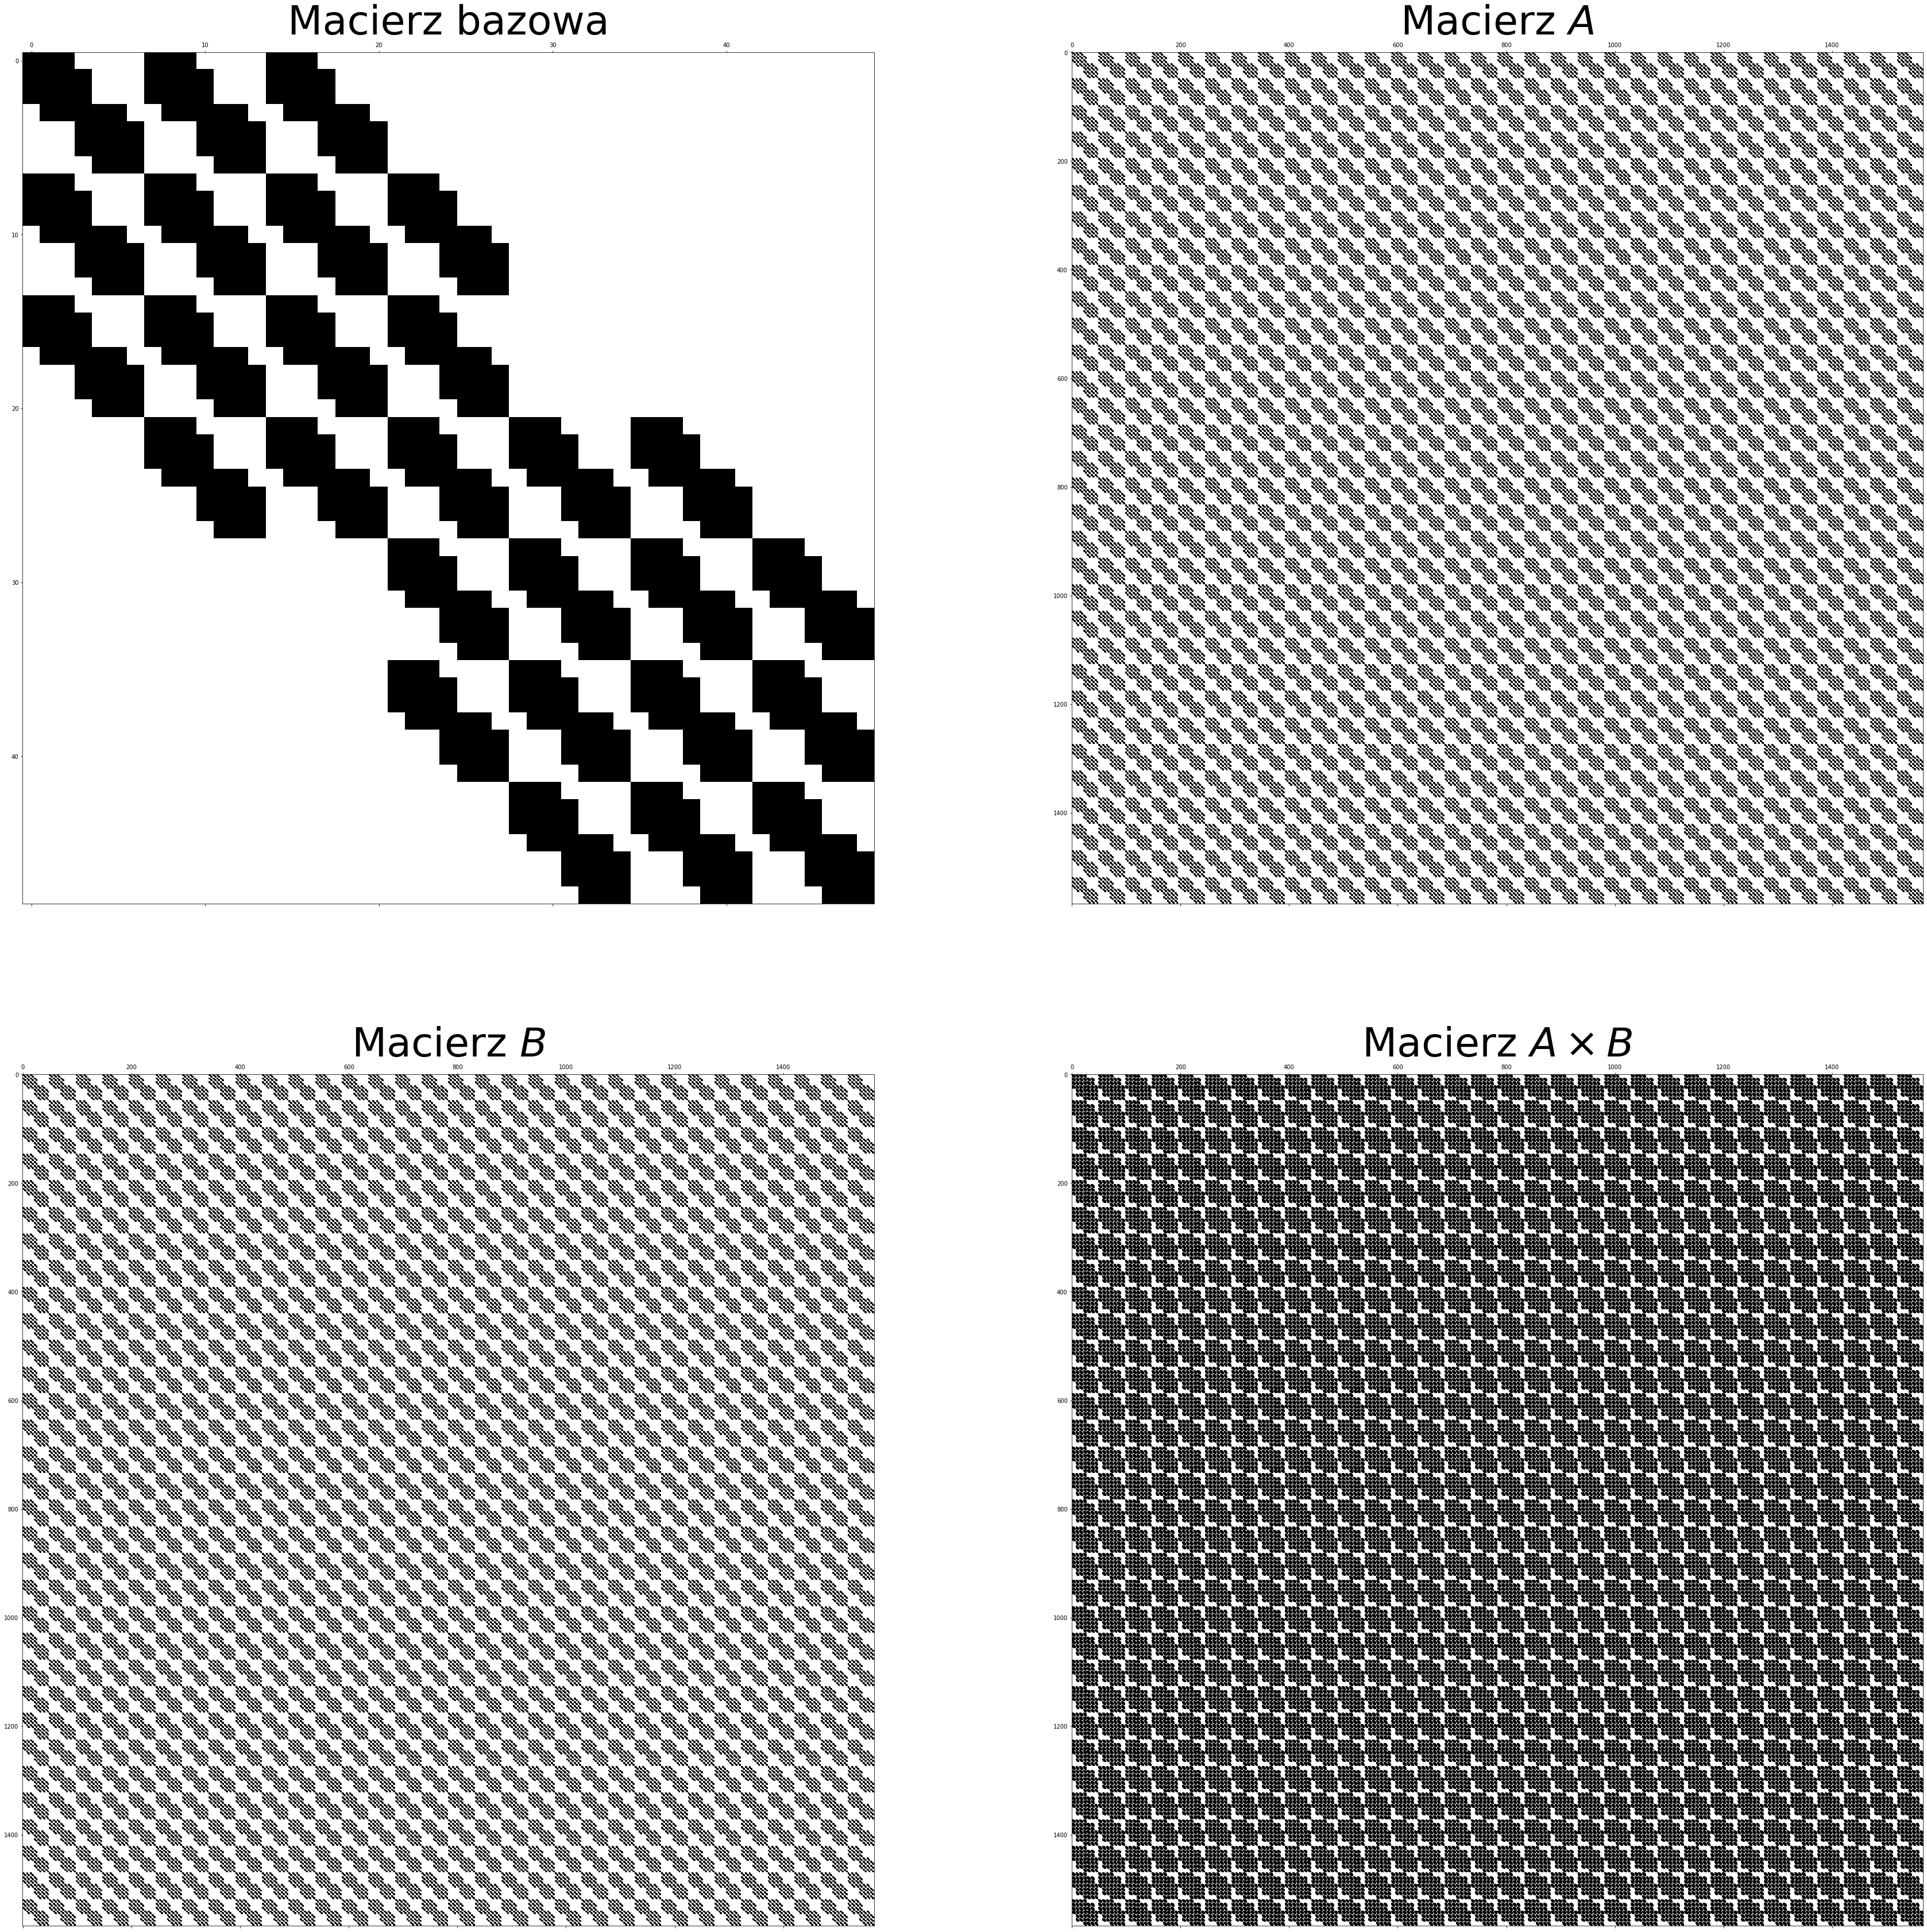

In [6]:
fig, axs = plt.subplots(2, 2, figsize = (60, 60))
axs = axs.flatten()
axs[0].spy(T)
axs[0].set_title('Macierz bazowa', fontsize=70)
axs[1].spy(A)
axs[1].set_title('Macierz $A$', fontsize=70)
axs[2].spy(B)
axs[2].set_title('Macierz $B$', fontsize=70)
axs[3].spy(AxB)
axs[3].set_title('Macierz $A \\times B$', fontsize=70)
plt.show()

# Program do mnożenia
Moduł do mnożenia macierzy został napisany w języku C oraz skompilowany z użyciem flagi $-o3$, w celu jak największej optymalizacji kodu maszynowego. Program wczytuje dwie macierze z plików w formacie csv, mnoży je używając określonej kolejności pętli (dzieląc na bloki lub nie) i zapisuje wynik w kolejnym pliku. Dodatkowo moduł mierzy czasy mnożenia. Kod źródłowy programu można znaleźć w pliku $prog.c$.

Dodatkowo została przygotowana minibiblioteka $iface.py$ wykorzystująca $prog.c$ i mogąca mnożyć macierze z biblioteki $numpy$, używając plików tymczasowych.

In [7]:
from iface import calc

# Testy kolejności pętli

Testy zostały wykonane na wybranej macierzy, na każdej możliwej kolejności pętli.

In [ ]:
orders = [
    'ijp',
    'ipj',
    'jip',
    'jpi',
    'pij',
    'pji'
]

def measure_time(A, B, orders=orders, tries=1):
    res_df = []
    for order in orders:
        sum_time = 0
        for _ in range(tries):
            time, _ = calc(A, B, order)
            sum_time = sum_time + time
        avg_time = sum_time / tries
        res_df.append([order, avg_time])
        print(f'{order}: {avg_time}')
    return pd.DataFrame(res_df, columns=('order', 'avg_time'))

In [ ]:
res_df = measure_time(A, B, tries=1)
res_df.rename(columns={'order': 'Order', 'avg_time': 'Average time [s]'})

ijp: 13.891
ipj: 1.155
jip: 13.328
jpi: 54.392
pij: 1.675
pji: 54.298


,Order,Average time [s]
0,ijp,13.891
1,ipj,1.155
2,jip,13.328
3,jpi,54.392
4,pij,1.675
5,pji,54.298


In [16]:
matrix_size = '$49 \\cdot 2^{5} \\times 49 \\cdot 2^{5}$'

<BarContainer object of 6 artists>

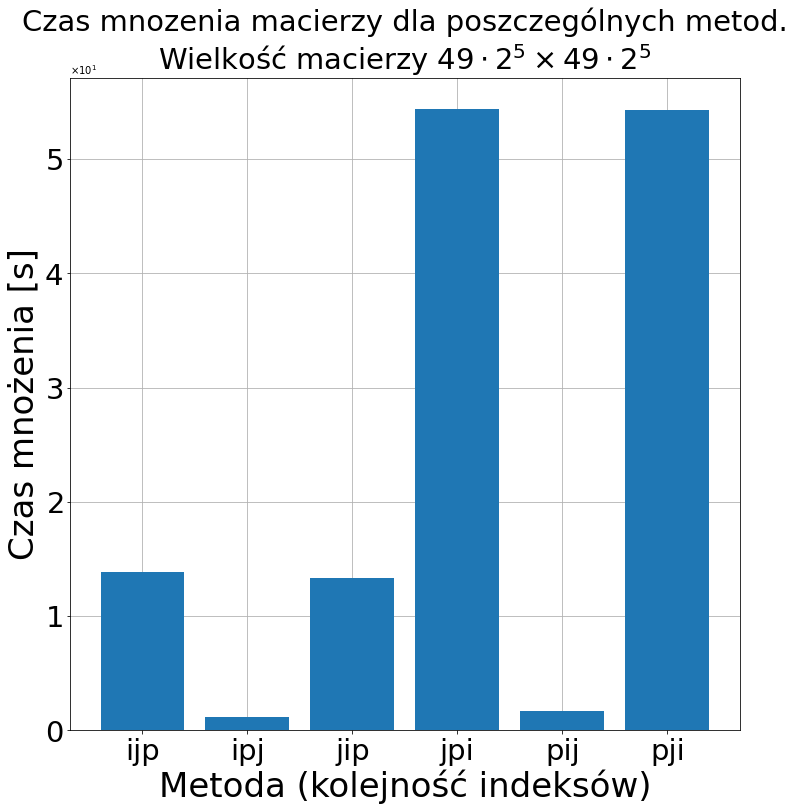

In [ ]:
xs, ys = res_df['order'], res_df['avg_time']
fig = plt.figure(figsize = (12, 12))
plt.title(f'Czas mnozenia macierzy dla poszczególnych metod.\nWielkość macierzy {matrix_size}', fontsize = 29)
plt.xlabel('Metoda (kolejność indeksów)', fontsize = 34)
plt.ylabel('Czas mnożenia [s]', fontsize = 34)
plt.tick_params(axis='both', which='major', labelsize = 29)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)
# plt.yscale('log')
plt.grid(zorder=-1)
plt.bar(xs, ys, zorder=3)

## Wnioski
Najszybsze okazały się kolejności $ipj$ oraz $pij$, po nich $ijp$, $jip$, najwolniejsze były $jpi$ i $pji$.



In [10]:
def measure_blocks(A, B, order, ns_blocks, tries=1):
    import math
    n = len(A)
    xs, avg_times = [], []
    for n_blocks in ns_blocks:
        sum_time = 0
        for _ in range(tries):
            block_size = math.ceil(n / n_blocks)
            if n_blocks == 1:
                block_size = 0
            time, _ = calc(A, B, order, block_size)
            sum_time = sum_time + time
        avg_time = sum_time / tries
        avg_times.append(avg_time)
    return ns_blocks, avg_times

# Testy mnożenia blokowego
Dla zadanej macierzy została wybrana kolejność pętli $ipj$.

## Testy dla kolejncych potęg liczby 2

Początkowo zostały przetestowane liczby bloków 1, 2, 4, 8, 16, ..., $\frac{n}{2}$, w celu znalezienia wstępnej optymalnej liczby bloków. 

In [9]:
def measure_blocks_2pow(A, B, order, tries=1):
    ns_blocks = np.logspace(0, 10, 10 - 0 + 1, base=2).astype(int)
    return measure_blocks(A, B, order, ns_blocks, tries)

In [13]:
xs, ys = measure_blocks_2pow(A, B, 'ipj', tries=1)

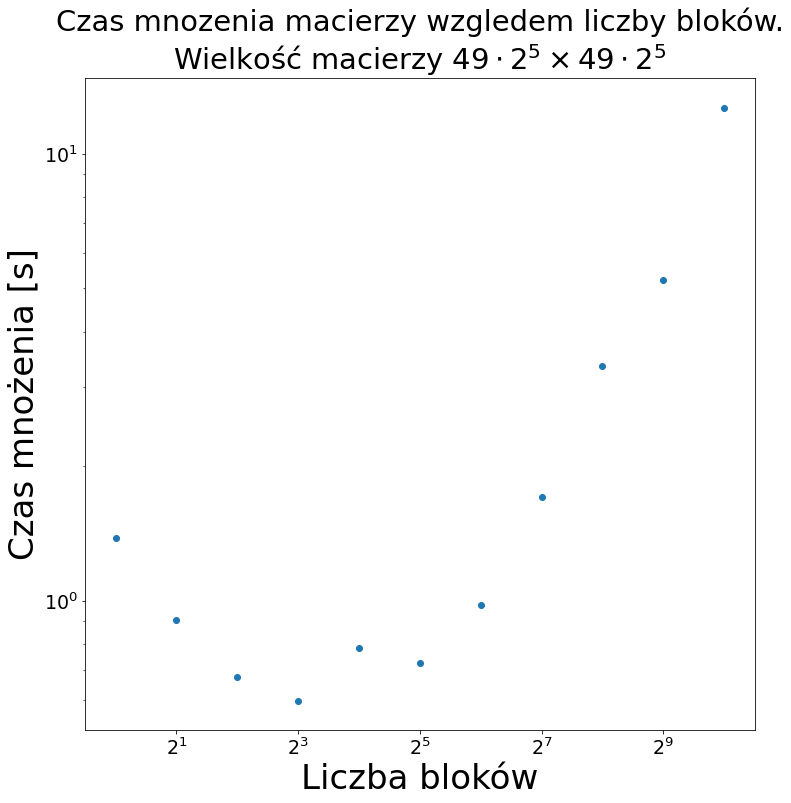

In [16]:
fig = plt.figure(figsize = (12, 12))
plt.title(f'Czas mnozenia macierzy wzgledem liczby bloków.\nWielkość macierzy {matrix_size}', fontsize = 29)
plt.xlabel('Liczba bloków', fontsize = 34)
plt.ylabel('Czas mnożenia [s]', fontsize = 34)
plt.xscale('log', base=2)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize = 19)
plt.scatter(xs, ys)

## Wnioski
Wstępne testy wykazały, że optymalna liczba bloków jest pomiędzy $4 \times 4$, a $16 \times 16$ blokami. 

## Testy dla liczby bloków pomiędzy 2 a 16 

In [36]:
def measure_blocks_lin(A, B, order, tries=1):
    ns_blocks = np.arange(1, 16).astype(int)
    return measure_blocks(A, B, order, ns_blocks, tries)

In [37]:
xs, ys = measure_blocks_lin(A, B, 'ipj', tries=1)

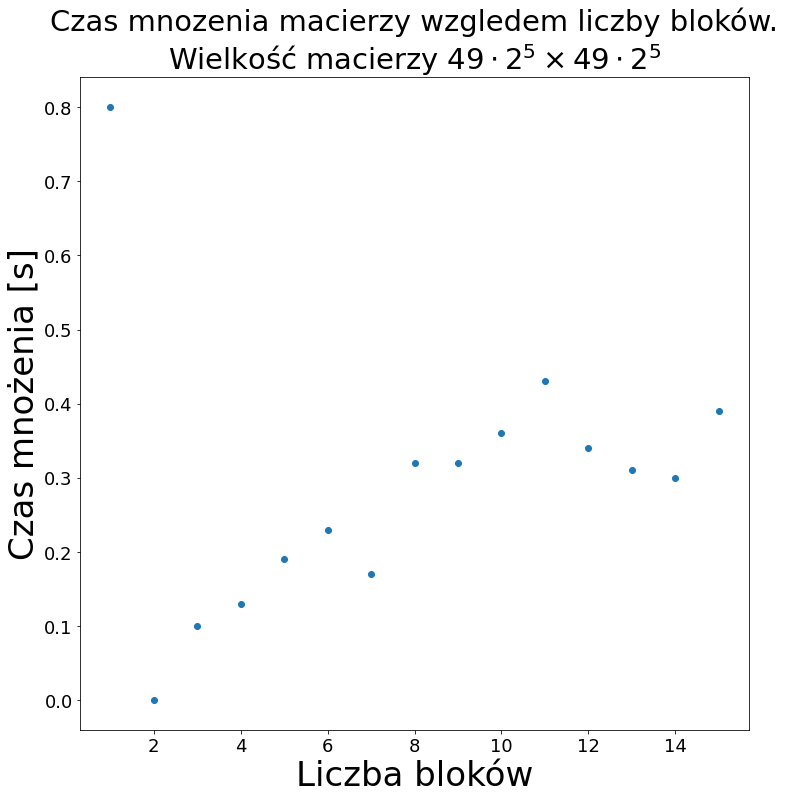

In [38]:
fig = plt.figure(figsize = (12, 12))
plt.title(f'Czas mnozenia macierzy wzgledem liczby bloków.\nWielkość macierzy {matrix_size}', fontsize = 29)
plt.xlabel('Liczba bloków', fontsize = 34)
plt.ylabel('Czas mnożenia [s]', fontsize = 34)
# plt.xscale('log', base=2)
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize = 18)
plt.scatter(xs, ys)

## Wnioski
Dla podanego zakresu ciężko stwierdzić, która liczba bloków jest najbardziej optymalna. Mimo wielokrotnego wykonania testów, wyniki zawsze podlegały znacznemu błędowi statystycznemu i były w znacznym stopniu zależne od wahań wydajności procesora. Udało się tylko ustalić, że optymalna licba bloków przypada pomiędzy $3$ a $16$.

# Podsumowanie

Najbadziej wydajną kolejnością pętli podczas mnożenia macierzy okazały się kolejności $ipj$ i $pij$, odstając znacząco od reszty permutacji pętli. Dla wybranej metody $ipj$ zostały wykonane testy liczby podziałów bloków, dla których mnożenie jest jeszcze szybsze, udało się ustalić, że ta liczba leży pomiędzy $4 \times 4$ a $16 \times 16$ bloków podziałów.

Niezależnie od metody, każde mnożenie wymagalo $3 \cdot m \cdot r \cdot t = 3 \cdot n^3 \cdot q^3$, gdzie $n=49$, $q=2^5$, co daje ostatecznie $11,565,367,296$ operacji zmiennoprzecinkowych.